In [162]:
import jax
import jax.numpy as jnp
import optax
from flax import nnx
from jax import random

from types import SimpleNamespace
import numpy as np
import time
from EconModel import EconModelClass, jit

In [163]:
import flax
from flax.core import FrozenDict

print("Flax version:", flax.__version__)

jax.devices()

Flax version: 0.12.0


[CpuDevice(id=0)]

## 1. Create neural network using FLAX

In [164]:
class Policy(nnx.Module):
  layers: list[nnx.Linear]
  
  def __init__(self, din: int, dout: int, neurons: list, rngs: nnx.Rngs):

    layers = []

    # 1st layer
    layers.append(nnx.Linear(din, neurons[0], rngs=rngs))
    
    # hidden layers
    for layer in range(len(neurons)-1):
      
      #setattr(self, f"layer{layer+2}", nnx.Linear(neurons[layer], neurons[layer+1], rngs=rngs))
      layers.append(nnx.Linear(neurons[layer], neurons[layer+1], rngs=rngs))

    # last layer
    layers.append(nnx.Linear(neurons[-1], dout, rngs=rngs))

    self.layers = nnx.List(layers)

    #self.din, self.dout, self.hidden_layers = din, dout, neurons
  
  def __call__(self, x: jax.Array):

    # 1st + hiden layers
    for layer in self.layers[:-1]:

      # unpack layer
      #layer = getattr(self, f"layer{i+1}")

      # forward x
      x = nnx.relu(layer(x))

    # last layer
    layer = self.layers[-1]

    y = jax.nn.sigmoid(layer(x))

    return y

def setup_nn(model):

  par = model.par
  train = model.sol

  T = par.T
  Nstates = par.Nstates
  Nactions = par.Nactions

  din = Nstates + T
  dout = Nactions
  neurons = train.neurons

  nn = Policy(din, dout, neurons, rngs=nnx.Rngs(params=0))

  return nn

def eval_policy(nn,x,t):

  # time dummies
  Nx = x.shape[0]
  Nstates = x.shape[1]
  T = nn.layers[0].in_features - Nstates
  
  time_dummies = jax.nn.one_hot(t, T) # shape (T,)
  time_dummies = jnp.broadcast_to(time_dummies, (Nx, T))
  
  x = jnp.concatenate((x,time_dummies),axis=-1)
  
  # evaluate
  action = nn(x)

  return action

### Test policy

In [165]:
# direcly evaluate Policy network
hidden_layers = [5,5,10]
din = 10
dout = 1

model = Policy(din, dout, hidden_layers, rngs=nnx.Rngs(params=0))
model(x=jnp.ones((1, din)))

Array([[0.5598746]], dtype=float32)

## 2. Create model class

In [166]:
class Model():

    par: dict
    train: dict
    sim: dict
    policy: Policy
    opt: nnx.Optimizer

    def __init__(self, N=None, T=None):

        par = {}
        train = {}
        sim = {}

        # a. model
        par["T"] = 5                     # number of periods

        # preferences
        par["beta"] = 1/1.01             # discount factor

        # income
        par["kappa_base"] = 1.0
        par["rho_p"] = 0.95              # shock persistence
        par["sigma_xi"] = 0.1            # permanent shock std
        par["sigma_psi"] = 0.1           # transitory shock std

        # return
        par["R"] = 1.01                  # gross return

        # b. solver settings
        par["Nstates"] = 2               # number of state variables
        par["Nactions"] = 1              # number of action variables
        par["Nshocks"] = 2               # number of shocks

        # c. simulation 
        sim = {}
        sim["N"] = 50_000                # number of agents

        # initial states
        par["mu_m0"] = 1.0               # initial cash-on-hand mean
        par["sigma_m0"] = 0.1            # initial cash-on-hand std

        # initial permanent income
        par["mu_p0"] = 1.0               # initial permanent income mean
        par["sigma_p0"] = 0.1            # initial permanent income std

        if T: par['T'] = T

        self.par = par

        sim['N'] = 100_000

        self.sim = sim

        # a. neural network

        train["neurons"] = [100, 100]     # number of neurons in hidden layers
        train["N"] = 3000                 # number of agents for training
        train["seed"] = 0                 # random seed
        train["learning_rate_policy"] = 1e-3   # learning rate for policy
        train['K'] = 1000

        if N: train['N'] = N

        self.train = train
        self.dtype = jnp.float32
        self.device = jax.devices("cpu")[0]


In [195]:
class MyModel(EconModelClass):
    
    # __init__ is inherited from EconModelClass
    
    def settings(self): # required
        """ choose settings """
            
        pass # nothing chosen here
    
    def setup(self): # required
        """ set free parameters """
        
        par = self.par
        train = self.sol
        sim = self.sim

        par.T = 5                     # number of periods

        # preferences
        par.beta = 1/1.01             # discount factor

        # income
        par.kappa_base = 1.0
        par.rho_p = 0.95              # shock persistence
        par.sigma_xi = 0.1            # permanent shock std
        par.sigma_psi = 0.1           # transitory shock std

        # return
        par.R = 1.01                  # gross return

        # solver settings
        par.Nstates = 2               # number of state variables
        par.Nactions = 1              # number of action variables
        par.Nshocks = 2               # number of shocks

        par.mu_m0 = 1.0        # initial cash-on-hand mean
        par.sigma_m0 = 0.1     # initial cash-on-hand std

        # initial permanent income
        par.mu_p0 = 1.0        # initial permanent income mean
        par.sigma_p0 = 0.1     # initial permanent income std

        train.neurons = [100, 100]            # number of neurons in hidden layers
        train.N = 3000                        # number of agents for training
        train.seed = 0                        # random seed
        train.learning_rate_policy = 1e-3     # learning rate for policy
        train.K = 1000

        sim.N = 10_000

    def allocate(self): # required
        """ set compound parameters and allocate arrays """
        
        train = self.sol
        
        train.initial_states_train, train.shocks_train = self.draw_all()
        train.iter_time = np.zeros(train.K) + np.nan

    def solve(self):

        with jit(self) as model_jit:
            model_jit.train_policy()

In [196]:
def draw_all(self):
    
    par = self.par
    train = self.sol
    sim = self.sim

    np.random.seed(0)

    sigma_m0 = par.sigma_m0
    sigma_p0 = par.sigma_p0
    sigma_xi = par.sigma_xi
    sigma_psi = par.sigma_psi

    K = train.K
    T = par.T
    N = train.N

    N_sim = sim.N

    # set global
    #global initial_states_train
    #global initial_states_test
    #global shocks_train
    #global shocks_test

    # draw training data
    m0_train = np.exp(np.random.normal(-0.5*sigma_m0**2,sigma_m0,size=(K, N)))
    p0_train = np.exp(np.random.normal(-0.5*sigma_p0**2,sigma_p0,size=(K, N)))

    initial_states_np = np.stack((m0_train,p0_train),axis=-1)
    initial_states_train = jnp.array(initial_states_np)

    psi_train = np.exp(np.random.normal(-0.5*sigma_psi**2,sigma_psi,size=(K, T, N)))
    xi_train = np.exp(np.random.normal(-0.5*sigma_xi**2,sigma_xi,size=(K, T, N)))

    shocks_np = np.stack((psi_train,xi_train),axis=-1)
    shocks_train = jnp.array(shocks_np)

    # draw test data
    m0_train = np.exp(np.random.normal(-0.5*sigma_m0**2,sigma_m0,size=(N_sim,)))
    p0_train = np.exp(np.random.normal(-0.5*sigma_p0**2,sigma_p0,size=(N_sim,)))

    initial_states_np = np.stack((m0_train,p0_train),axis=-1)
    initial_states_test = jnp.array(initial_states_np)

    psi_train = np.exp(np.random.normal(-0.5*sigma_psi**2,sigma_psi,size=(T, N_sim)))
    xi_train = np.exp(np.random.normal(-0.5*sigma_xi**2,sigma_xi,size=(T, N_sim)))

    shocks_np = np.stack((psi_train,xi_train),axis=-1)
    shocks_test = jnp.array(shocks_np)

    return initial_states_train, shocks_train

MyModel.draw_all = draw_all

### Test policy through class

In [197]:
model = MyModel()
nn =  setup_nn(model)

x = 20*jnp.ones((1,model.par.Nstates))
eval_policy(nn,x,t=1)

Array([[0.9248638]], dtype=float32)

### Test jitted policy through class

In [198]:
jax.jit(eval_policy)(nn,x,t=1)

Array([[0.9248638]], dtype=float32)

## 4. Model functions and simulate

In [199]:
def outcomes(states,actions):
	""" outcomes - just consumption here """

	m = states[...,0] # cash-on-hand
	a = actions[...,0] # savings rate
	c = m*(1-a) # consumption

	return jnp.stack((c,),axis=-1) # (T,N,Noutcomes)

def state_trans(par,states,outcomes,shocks):
	""" transition to future state """

	# a. unpack
	xi = shocks[...,0] # permanent income shock
	psi = shocks[...,1] # transitory income shock
	m = states[...,0]
	p = states[...,1]
	c = outcomes[...,0]

	# c. post-decision
	m_pd = m-c
	
    # d. persistent income
	p_plus = p**par.rho_p * xi # permanent income
	
    # d. income
	income = par.kappa_base * p_plus * psi # income
	
    # e. future cash-on-hand
	m_plus = par.R * m_pd + income # future cash-on-hand

	# d. finalize
	states_pd = jnp.stack((m_plus,p_plus),axis=-1)
	return states_pd

def utility(c):
	""" utility """

	#c_ = jnp.clip(c, 1e-2, None) # avoid log(0)

	return jnp.log(c)

def reward(outcomes):
	""" reward """

	# b. consumption
	c = outcomes[...,0]

	# c. utility
	u = utility(c)

	return u 

In [200]:
def simulate_loss(par, nn, initial_states, shocks):

    def scan_step(states_t, t):
        """One period transition in simulation."""

        # Policy
        actions_t = eval_policy(nn, states_t, t)

        # Outcomes & reward
        outcomes_t = outcomes(states_t, actions_t)
        reward_t = reward(outcomes_t)

        # Transition to next state
        next_states = state_trans(par, states_t, outcomes_t, shocks[t])

        return next_states, (reward_t,)

    # construct manual iterator
    ts = jnp.arange(par.T)

    # call scanner and pass initial states as first states_t
    _, (reward_seq,) = jax.lax.scan(scan_step, initial_states, ts) # discard states in simulation

    # discount
    discounts = par.beta**jnp.arange(par.T)
    discounted_sum = jnp.sum(discounts[:, None] * reward_seq, axis=0)

    # Average objective over training samples
    loss = -jnp.mean(discounted_sum)

    return loss

## 5. Training

In [201]:
def train_step(par, nn, initial_states, shocks):

    def loss_fn(nn_):
        return simulate_loss(par, nn_, initial_states, shocks)

    loss, grads = jax.value_and_grad(loss_fn)(nn)
    
    return loss, grads

def train_policy(model):

    t0 = time.perf_counter()

    par = model.par
    train = model.sol
    
    # create optimizer and neural network
    nn = setup_nn(model)
    lr = train.learning_rate_policy

    policy_opt = nnx.ModelAndOptimizer(nn, optax.adam(learning_rate=lr))
    train_step_jit = jax.jit(train_step, static_argnums=(0))
    
    initial_states_train, shocks_train = train.initial_states_train, train.shocks_train

    # training loop
    for k in range(train.K):

        initial_states = initial_states_train[k]
        shocks = shocks_train[k]

        loss, grads = train_step_jit(par, nn, initial_states, shocks)

        policy_opt.update(grads)

        # iv. print progress
        if k % 10 == 0:
            print(f"Iteration {k}: Loss {loss.item()}")

        train.iter_time[k] = time.perf_counter()-t0

MyModel.train_policy = train_policy

In [202]:
model = MyModel()

In [203]:
model.solve()

Iteration 0: Loss 1.4592036008834839
Iteration 10: Loss 0.3410794138908386
Iteration 20: Loss 0.16268207132816315
Iteration 30: Loss 0.10668126493692398
Iteration 40: Loss 0.10078403353691101
Iteration 50: Loss 0.11616367101669312
Iteration 60: Loss 0.09111995995044708
Iteration 70: Loss 0.09416574984788895
Iteration 80: Loss 0.10953684151172638
Iteration 90: Loss 0.0902084931731224
Iteration 100: Loss 0.07315880060195923
Iteration 110: Loss 0.10105960816144943
Iteration 120: Loss 0.08488869667053223
Iteration 130: Loss 0.08187302201986313
Iteration 140: Loss 0.08261433243751526
Iteration 150: Loss 0.06982419639825821
Iteration 160: Loss 0.0655754879117012
Iteration 170: Loss 0.07263153046369553
Iteration 180: Loss 0.0900285467505455
Iteration 190: Loss 0.10107329487800598
Iteration 200: Loss 0.09637176245450974
Iteration 210: Loss 0.08995111286640167
Iteration 220: Loss 0.08638092130422592
Iteration 230: Loss 0.07697977125644684
Iteration 240: Loss 0.07011783123016357
Iteration 250: L

In [68]:
base = 10000

Ts = [1, 2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50] + [55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

times = np.zeros(len(Ts)) + np.nan

for i_t, t in enumerate(Ts):
    
    t0 = time.perf_counter()
    
    model = Model(N=base, T=t) # create model object
    
    train_policy(model) # train policy

    times[i_t] = time.perf_counter() - t0

Iteration 0: Loss 0.7371875047683716
Iteration 10: Loss 0.08829497545957565
Iteration 20: Loss 0.025199443101882935
Iteration 30: Loss 0.012974199838936329
Iteration 40: Loss 0.007960982620716095
Iteration 50: Loss 0.008080583065748215
Iteration 60: Loss 0.006515211891382933
Iteration 70: Loss 0.005166305229067802
Iteration 80: Loss 0.005398693028837442
Iteration 90: Loss 0.0055967457592487335
Iteration 100: Loss 0.0061430661007761955
Iteration 110: Loss 0.005670497659593821
Iteration 120: Loss 0.005313219968229532
Iteration 130: Loss 0.005506480112671852
Iteration 140: Loss 0.004100146237760782
Iteration 150: Loss 0.006662364117801189
Iteration 160: Loss 0.004660042002797127
Iteration 170: Loss 0.005811668932437897
Iteration 180: Loss 0.0048632314428687096
Iteration 190: Loss 0.004583041649311781
Iteration 200: Loss 0.004771729931235313
Iteration 210: Loss 0.0059467884711921215
Iteration 220: Loss 0.004975947551429272
Iteration 230: Loss 0.005416672211140394
Iteration 240: Loss 0.0052

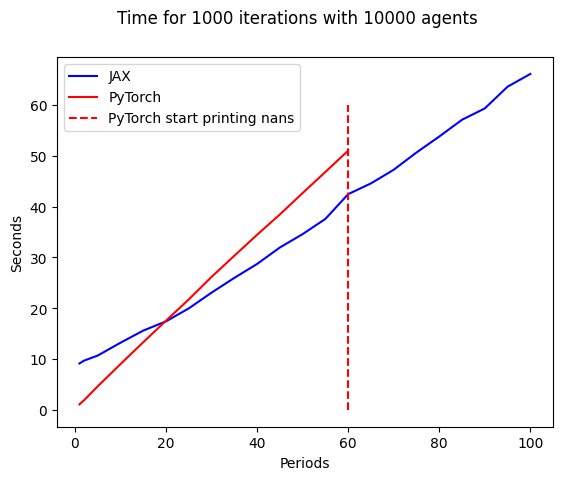

In [106]:
f, ax = plt.subplots()

ax.plot(Ts, times, label='JAX', color='blue')
ax.plot(Ts, times_pytorch, label='PyTorch', color='red')
ax.set_ylabel('Seconds')
ax.set_xlabel('Periods')
ax.vlines(60, 0, 60, color='red', linestyles='--', label ='PyTorch start printing nans')
ax.legend()
f.suptitle('Time for 1000 iterations with 10000 agents');

f.savefig('JAX_vs_PyTorch_number_of_periods.png')